In [0]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt 
%matplotlib inline  

# 1) Build an MC algorithm that computes the mean of any given distribution
You will train your algorithm on the following density mixture_d_2. If your algorithm needs to be restricted to a compact set. You can only choose $[-10,10]^2$ but it is not allowed to take $[0,10]^2$ (this information is obtained by visualizing which is not always the case). You will first present your algorithm and then evaluate its performance according to different budget $(1000,5000,10000)$ using the averaged squared error computed over, at least, $50$ trials. If $A_1,\ldots, A_{50}$ are realization of your algorithm and $\mu$ is the true value, the average squared error computed over $50$ trials is
$$\frac{1}{50} \sum_{i=1} ^{50} (A_i - \mu)^2$$ 


In [0]:
#gaussian mixture on the unit cube
def mixture_d_2(x):
    x1 = x - np.matrix([3,7])
    x2 = x - np.matrix([7,2])
    x3 = x - np.matrix([7,7])
    return (.2 * np.prod(norm.pdf(x1)) + .4 * np.prod(norm.pdf(x2)) + .4 * np.prod(norm.pdf(x3))) 

In [0]:
mixture_d_2([1,1])

6.536828823691848e-10

In [0]:
#We code the gaussion mixture ourselves for computational Scomplexity purposes
def mixture_d_2(x):
    x=np.matrix(x)
    x1 = x - np.matrix([3,7])
    x2 = x - np.matrix([7,2])
    x3 = x - np.matrix([7,7])
    return float(.2*1/(2*np.pi)*np.exp(-1/2*np.inner(x1,x1))+.4*1/(2*np.pi)*np.exp(-1/2*np.inner(x2,x2))+.2*1/(2*np.pi)*np.exp(-1/2*np.inner(x3,x3)))

In [0]:
mixture_d_2([1,1])

6.536828749859142e-10

# Here is a plot of the density

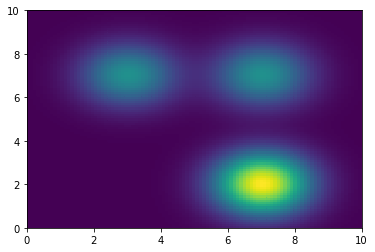

In [0]:
N = 100
z = np.zeros([N,N])
x = np.zeros([N,N])
y = np.zeros([N,N])
xmin = 0
xmax = 10
ymin = 0
ymax = 10

x1 = np.linspace(xmin,xmax,N)
y1 = np.linspace(ymin,ymax,N)
for i in range(N):
    for j in range(N):
        x[i,j] = x1[i]
        y[i,j] = y1[j]
        z[i,j] = mixture_d_2([x1[i],y1[j]])

plt.pcolormesh(x,y,z)
plt.show()

# Variance-Reduction Based importance sampling

We will first try to evaluate the average of mixture_d_2 by using a variance-reduction based importance sampling.

Our first approach is to minimize the risk over the parameter space $\Theta$ where $f_{\Theta}$ represents the gaussian 1-D density functions.

We use the inition distribution q0 as a uniform distribution on $[-10,10]^{2}$

For the uniform distribution, there is no parameter theta to minimize so we can immediately approximate the integral

The choice of the q distribution is of utmost importance, as it has an effect on the variance of the method.
Our q is optimal if it is proportional to $\varphi$

We want to $min_{q \in Q} $ $var_{q}\frac{\varphi}{q}$

In [0]:
#importance sampling algorithm - Using the Variance method
#Step one of the unified view algorithm
##We generate n1 i.i.d points
##For this we will use a uniform distribution over [-10,10]^2 (we can improve this later with a different distribution)
n1 = 100
##Exploration
x = np.random.uniform(-10,10,n1) 
y = np.random.uniform(-10,10,n1)
eval_points = list(zip(x,y))

##Exploitation
def q(theta_1,theta_2,x):
    return np.prod(norm.pdf(x-np.matrix([theta_1,theta_2])))
    
eval_phi = [mixture_d_2(eval_points[i]) for i in range(n1)]
eval_q0 = [1/(20**2) for i in range(n1)]


def R_hat_1(theta_1,theta_2):
    eval_q = [q(theta_1,theta_2,point) for point in eval_points]
    return 1/n1*sum([eval_phi[i]**2/(eval_q0[i]*eval_q[i]) for i in range(n1)])
    


xx , yy = np.meshgrid(np.linspace(-10,10,20),np.linspace(-10,10,20)) #meshgrid(theta_1,theta_2)
zz = np.zeros((50,50))

zz_min = np.inf
theta_1_min = 0
theta_2_min = 0

for i in range(20):
    for j in range(20):
        zz[i, j] = R_hat_1(xx[i,j],yy[i,j])##we iterate over theta to find the best gaussian to approximate our mixture
        if zz[i, j] <= zz_min :
            zz_min = zz[i, j]
            theta_1_min = xx[i, j]
            theta_2_min = yy[i, j]     

In [0]:
print('theta_1_min : '+str(theta_1_min))
print('theta_2_min : '+str(theta_2_min))

theta_1_min : 5.789473684210526
theta_2_min : 4.7368421052631575


In [0]:
#Real theta: 
avg = 0.2*np.array([3,7])+0.4*np.array([7,2])+0.4*np.array([7,7])
avg

array([6.2, 5. ])

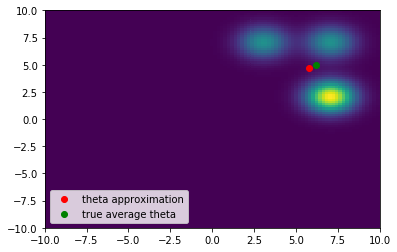

In [0]:
N = 100
z = np.zeros([N,N])
x = np.zeros([N,N])
y = np.zeros([N,N])
xmin = -10
xmax = 10
ymin = -10
ymax = 10

x1 = np.linspace(xmin,xmax,N)
y1 = np.linspace(ymin,ymax,N)
for i in range(N):
    for j in range(N):
        x[i,j] = x1[i]
        y[i,j] = y1[j]
        z[i,j] = mixture_d_2([x1[i],y1[j]])

plt.pcolormesh(x,y,z)
plt.scatter([theta_1_min], [theta_2_min], marker='o', c="red", label="theta approximation") #The red dot in the graph will correspond to the theta we use in our gaussian approximation
plt.scatter(avg[0],avg[1], marker='o', color="g",label="true average theta") #The green dot corresponds to the real average theta of the mixture
plt.legend(loc='lower left')
plt.show()

The q_theta_1 function we will use will be a gaussian with mean [theta_1_min,theta_2_min] (the red point in the above plot)

In [0]:
#Step 2, now we can evaluate the value of the integral
##We generate n2 data points under a normal distribution (mean: [theta_1,theta_2])
##We will use a budget of 1000-100 = 900
def variance_reduction():

    n2 = 900 #budget is 1000 to begin with
    x = np.random.normal(loc=theta_1_min,size= 900)
    y = np.random.normal(loc=theta_2_min,size= 900)

    eval_points = list(zip(x,y)) #corresponds to X1, ..., Xn2
    phi_values = [mixture_d_2(point) for point in eval_points] 
    q_theta_2 = [np.prod(norm.pdf(np.matrix(point)-np.matrix([theta_1_min,theta_2_min]))) for point in eval_points]
    I_hat_2 = 1/n2*sum([phi_values[i]/q_theta_2[i] for i in range(n2)])
    return I_hat_2

def error():
    error_list = [(variance_reduction()-1)**2 for i in range(50)]
    return 1/50*sum(error_list)

In [0]:
print('The error of our Variance-Reduction Algorithm is : '+str(error()))

The error of our Variance-Reduction Algorithm is : 0.14864216641300304


# Limitations of Variance Reduction

The problem with this initial approach is that it will not work for distributions where the centres of gaussians are far away, or opposed. As shown below.

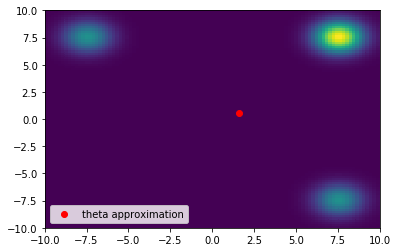

In [0]:
def new_mixture(x):
    x=np.matrix(x)
    x1 = x - np.matrix([-7.5,7.5])
    x2 = x - np.matrix([7.5,7.5])
    x3 = x - np.matrix([7.5,-7.5])
    return float(.2*1/(2*np.pi)*np.exp(-1/2*np.inner(x1,x1))+.4*1/(2*np.pi)*np.exp(-1/2*np.inner(x2,x2))+.2*1/(2*np.pi)*np.exp(-1/2*np.inner(x3,x3)))

n1 = 100
##Exploration
x = np.random.uniform(-10,10,n1) 
y = np.random.uniform(-10,10,n1)
eval_points = list(zip(x,y))

##Exploitation
def q(theta_1,theta_2,x):
    return np.prod(norm.pdf(x-np.matrix([theta_1,theta_2])))

eval_phi = [new_mixture(eval_points[i]) for i in range(n1)]
eval_q0 = [1/(20**2) for i in range(n1)]


xx , yy = np.meshgrid(np.linspace(-10,10,20),np.linspace(-10,10,20)) #meshgrid(theta_1,theta_2)
zz = np.zeros((50,50))

zz_min = np.inf
theta_1_min = 0
theta_2_min = 0

for i in range(20):
    for j in range(20):
        zz[i, j] = R_hat_1(xx[i,j],yy[i,j])##we iterate over theta to find the best gaussian to approximate our mixture
        if zz[i, j] <= zz_min :
            zz_min = zz[i, j]
            theta_1_min = xx[i, j]
            theta_2_min = yy[i, j]     

N = 100
z = np.zeros([N,N])
x = np.zeros([N,N])
y = np.zeros([N,N])
xmin = -10
xmax = 10
ymin = -10
ymax = 10

x1 = np.linspace(xmin,xmax,N)
y1 = np.linspace(ymin,ymax,N)
for i in range(N):
    for j in range(N):
        x[i,j] = x1[i]
        y[i,j] = y1[j]
        z[i,j] = new_mixture([x1[i],y1[j]])

plt.pcolormesh(x,y,z)
plt.scatter([theta_1_min], [theta_2_min], marker='o', c="red", label="theta approximation") #The red dot in the graph will correspond to the theta we use in our gaussian approximation
plt.legend(loc='lower left')
plt.show()

Clearly, the 2-D gaussian model is unsatisfactory. We will use a non-parametric approach from now on: Gaussian Kernel NPAIS


# A new approach : AIS

In [0]:
#We will generate under X_i, so we need to use rejection sampling
#generate under density function f

def normal(x): #probability density function of normal distribution at x
    n=np.shape(x)[-1]
    return (1/(np.sqrt(2*np.pi)))*np.exp(-(1/2)*np.inner(x,x))

def g(x):
    return 1/20**2*(np.abs(x[0])<10)*(np.abs(x[1])<10)

C = 20**2/(2*np.pi)

In [0]:
def reject_method(f,n):
    X_f = [] #Xi that have been generated under f
    compteur = 0
    while len(X_f) < n:
        X = np.random.uniform(low=-10,high=10,size=(n,2)) #Creates n 2-d vectors under a uniform distribution
        U = np.random.uniform(low=0,high=1,size=(n,1))
        for i in range(n):
            if f(X[i])/(C*g(X[i])) >= U[i]:
                X_f.append(X[i])
            compteur += 1
    return X_f[:n],compteur

In [0]:
reject_method(mixture_d_2,5)[0]

[array([2.86510372, 7.06773774]),
 array([4.50224729, 5.38880937]),
 array([2.29329987, 6.32134805]),
 array([7.00859936, 2.42958213]),
 array([1.7832111 , 6.95039372])]

An immediate observation is that the rejection method is extremely costly. The vast majority of budget points will be rejected.

In [0]:
print('To get 5 points, we need to evaluate the mixture on : '+ str(reject_method(mixture_d_2,5)[1])+' points')

To get 5 points, we need to evaluate the mixture on : 330 points


We will thus use NPAIS where we will select the density to be evaluated with probability $\lambda$.

We select $q_0$ with probability $\lambda$ and another density with probability $1-\lambda$ that will be updated.

The updated density has been selected under a binomial law of parameter $W$ - a vector which contains all the weights of the drawn variables.

We use Gaussian Kernels when updating our density

In [0]:
def npais(phi, T, q0, lmbda, h, dim, N):
    
    q, S, I = q0, 0, 0
    nt = int(N/T) #Each iteration has same amount of points
    Nt = nt### N is the total number of evaluation points
    w = [1/nt for i in range(nt)]
    x = np.zeros((nt,dim))
    
    for t in range(1,T):
        for i in range(nt):
            if (np.random.binomial(1,lmbda[t]) == 1):
                x[i] = np.array([20*np.random.random() - 10 for k in range(dim)])
            else:
                indice = np.random.multinomial(1, w) @ np.array([k for k in range(len(w))]).T
                x[i] = np.random.normal(x[indice], h)
                
        
        poids = [phi(x[i])/q(x[i]) for i in range(nt)]
            
        norm = sum(poids)
        S += norm
        Nt += nt
        I = S/Nt
        
        w = list(np.array(poids)/norm)
        
        
        f_t_tilde = lambda z : np.sum([w[j]*normal((z-x[j])/h) for j in range (nt)]) #use of gaussian kernels
        q = lambda x : (1-lmbda[t])*f_t_tilde(x) + lmbda[t]*q0(x)
        
    return I

As you may have noticed in the above code, we have opted to remove a degree of freedom to simplify the problem: 

By imposing nt = N//T, we are considering the same amount of steps (nt) for each iteration t, whether it be in the exploration or exploitation phases.

In [6]:
npais(mixture_d_2,100, lambda x: 1/400, [1/((n)**0.4) for n in range(1,1001)], 0.31, 2, 1000)

0.8622205303641036

# Optimisation of our NPAIS parameters

Firstly, we need to set up an error function that we will minimize

In [0]:
#PSEUDO CODE
def error_50_iterations(parameter):
    prediction = npais(parameter)
    target = 1 #integration of the density mixture over its support is equal to 1
    error_list = [(prediction-target)**2 for i in range(50)]
    return sum(error_list)

We will fix our number of points at N = 1000

Optimal amount of exploitation iterations : $T$

Optimal weight sequence : $\lambda_{n}$

In [0]:
T_error_list = []
for T in range(1,1001,10): #If we have a budget of 1000 points, we have at most 1000 steps, we will use a step of 10 for computational purposes
    error_list = [(npais(mixture_d_2, T, lambda x: 1/400, [1/((n)**0.5) for n in range(1,1001)], 0.1, 2, 1000)-1)**2 for j in range(50)]
    T_error_list.append(sum(error_list))
np.argmin(T_error_list)

11

In [0]:
T_optimal = range(1,1001,10)[11]

Optimal Kernel parameter : $h$

We will vary h from $10^{-5}$ to $1$ 

To do this, we will consider the log of h

In [0]:
h_error_list = []
for logh in np.arange(-5*np.log(10),0,0.5): #If we have a budget of 1000 points, we have at most 1000 steps, we will use a step of 10 for computational purposes
    error_list = [(npais(mixture_d_2, T_optimal, lambda x: 1/400, [1/((n)**0.5) for n in range(1,1001)], np.exp(logh), 2, 1000)-1)**2 for j in range(50)]
    h_error_list.append(sum(error_list))
np.argmin(h_error_list)

21

In [0]:
h_optimal = np.exp(np.arange(-5*np.log(10),0,0.5)[21])

Optimal Kernel parameter : $\lambda_{n}$

We iterate over $s$ in $\frac{1}{n^{s}}$

In [0]:
lambda_error_list = []
for s in np.arange(0.01,0.9,0.01): #If we have a budget of 1000 points, we have at most 1000 steps, we will use a step of 10 for computational purposes
    error_list = [(npais(mixture_d_2, T_optimal, lambda x: 1/400, [1/((n)**s) for n in range(1,1001)], h_optimal, 2, 1000)-1)**2 for j in range(50)]
    lambda_error_list.append(sum(error_list))
np.argmin(lambda_error_list)

4

In [0]:
s_optimal = np.arange(0.01,0.9,0.01)[4]

In [0]:
print('T optimal : '+ str(T_optimal))
print('h optimal : '+str(h_optimal))
print('s optimal : '+str(s_optimal))

T optimal : 111
h optimal : 0.36315502674246564
s optimal : 0.05


# Tests for N=1000,5000,10000

In [0]:
def error(N):
    return 1/50*sum([(npais(mixture_d_2, T_optimal, lambda x: 1/400, [1/((n)**s_optimal) for n in range(1,1001)], h_optimal, 2, N)-1)**2 for j in range(50)])

  

In [0]:
print('Error for N = 1000 iterations : '+str(error(1000)))
print('Error for N = 5000 iterations : '+str(error(5000)))
print('Error for N = 10000 iterations : '+str(error(10000)))


Error for N = 1000 iterations : 0.01455619122025113
Error for N = 5000 iterations : 0.08185612747097386
Error for N = 10000 iterations : 0.14988358836498386


The order of magnitude of the error of our algorithm for 1000 points is $10^{-2}$ 

It is surprising that the error increases with the budget N that is allocated, but this is possibly because our optimized parameters h,s and T were obtained for N=1000.

There is no reason why these parameters should stay the same for N=5000 or N=10000

# 2) Compare your algorithm to the basic MC methods with uniform sampling on the cube [0,10]^2
(note that such a method has an additional information with respect to yours, which is the suppoet information [0,10]^2)

The comparison will be made with respect to a budget of $10000$ particles using the average squared error computed over at least $50$ trials.

In [0]:
import numpy as np
def monte_carlo():
    x = np.random.uniform(0,10,10000)
    y = np.random.uniform(0,10,10000)
    phi_list = [100*mixture_d_2(np.array(x[i],y[i])) for i in range(10000)]
    return 1/10000*np.sum(phi_list)

In [0]:
def error():
    return 1/50*sum([(monte_carlo()-1)**2 for j in range(50)])

In [0]:
print('Monte Carlo Error for 10000 points is : '+str(error()))

Monte Carlo Error for 10000 points is : 0.1792656435161762


# 3) A larger dimension?

Provide a deescription of your algorithm (if different than before).
Evaluate its performance when computing the average of mixture_d_5 with different sample sizes $(1000, 5000, 10000)$. You will use again the average squared error computed over at least 5050 trials.


In [0]:
def mixture_d_5(x):
    x1 = np.matrix(x) - np.matrix([3,5,0,0,0])
    x2 = np.matrix(x) - np.matrix([7,5,0,0,0])
    return .5 * np.prod(norm.pdf(x1)) + .5 * np.prod(norm.pdf(x2))

In [0]:
#We code the gaussion mixture ourselves for computational Scomplexity purposes
def mixture_d_5(x):
    x=np.matrix(x)
    x1 = x - np.matrix([3,5,0,0,0])
    x2 = x - np.matrix([7,5,0,0,0])
    return float(.5*1/(2*np.pi)*np.exp(-1/2*np.inner(x1,x1))+.5*1/(2*np.pi)*np.exp(-1/2*np.inner(x2,x2)))

In [27]:
npais(mixture_d_5,111, lambda x: 1/3200000, [1/((n)**0.05) for n in range(1,1001)], 0.36, 5, 1000)

1.1914368112640477

In [0]:
def error(N):
    return 1/50*sum([(npais(mixture_d_5,111, lambda x: 1/3200000, [1/((n)**0.05) for n in range(1,N+1)], 0.36, 5, N)-1)**2 for i in range(50)])

In [15]:
print('Error of NPAIS over N = 1000 points : '+str(error(1000)))
print('Error of NPAIS over N = 5000 points : '+str(error(5000)))
print('Error of NPAIS over N = 10000 points : '+str(error(10000)))

Error of NPAIS over N = 1000 points : 2775.088924117066
Error of NPAIS over N = 5000 points : 39029.528068688815
Error of NPAIS over N = 10000 points : 105792.39942093552


This NPAIS Algorithm does not scale well to higher dimensions...

# 4) Two new densities (respectively on $\mathbb R^2$ and $\mathbb R^5$) will be given to you during the last computer class. You will provide the accuracy (as before) of your method computing the mean with respect to these densities.

You will use $10000$ particles. And compute the average squared error with $50$ trials.